# This notebook shows how to find optimized parameters of simple enzyme kinetics. 


Read about scipy optimization methods https://docs.scipy.org/doc/scipy/reference/optimize.html

Import reqired python modules

In [1]:
import numpy as np # numeric python module for vectorized operations on arrays 
import pandas # convenience wrap for numpy 
from scipy.integrate import odeint # function for solving ordinary differential equations
from scipy.special import lambertw # implementation of Lambert W function
from scipy.optimize import minimize,basinhopping,differential_evolution #optimization algorithms
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt # plotting graphics library
#%matplotlib auto
#plt.ioff() # I prefer to output graphs into separate windows rather than showing them inline.
%matplotlib inline 

#### We will fit data to 4 different models: 
1. Standard Steady-state approximation (Michaelis-Menten equation);
$$velocity=-\frac{\mathrm{d} [S]}{\mathrm{d} t}=\frac{V_{max}[S]}{K_{M}+[S]
}$$
where [S] – substrate concentration, Vmax – maximal rate, KM  – Michaelis constant; condition: [E]o << [S]o

2. Total Steady-state approximation (Total Michaelis-Menten equation);
$$-\frac{\mathrm{d} [S]}{\mathrm{d} t}=k_{cat}\frac{[E]_{o}+K_{M}+[S]-\sqrt{([E]_{o}+K_{M}+[S])^{2}-4E_{o}[S]}}{2
}$$

3. Analytical solution of Michaelis-Menten equation (via Lambert W function).
$$[S]=K_{M}LambertW\left \{ {\frac{[S]_{o}}{K_{M}}exp\left ( {\frac{[S]_{o}-V_{max}t}{K_{M}}} \right )} \right \}$$
4. First order approximation.
$$velocity=-\frac{\mathrm{d} [S]}{\mathrm{d} t}=\frac{V_{max}[S]}{K_{M}}$$
In all examples, we will monitor substrate concentration [S].


# Standard Steady-state approximation. Detailed explanation.
$$velocity=-\frac{\mathrm{d} [S]}{\mathrm{d} t}=\frac{V_{max}[S]}{K_{M}+[S]
}$$

#### Define model and objective function for Standard Steady-state Approximation
This is an objective function (cost function), for which we will attempt to find global minimum. Our cost function will be the sum of squared residuals for all experimental concentrations (RMSE). Since binding constants can vary in a broad range, we will optionally vary them on log scale (condition "logbounds"). The cost function takes a set of constants and experimental data and returns RMSE.

In [21]:
def modelMM(S,t,*args): #Standard Quasi Steady-State Approximation
    KM,Vm=args #These are parameters that have to be optimized
    dSdt=-Vm*S/(KM+S) # differential equation
    return (dSdt)# returns rates of concentration change

def costMM(consts,*ARGS):  #consts are the current parameters (rate constants)
    data=ARGS[0]  # the DataFrame with experimental data points
    t=data['time'].values
    So=ARGS[1] # initial concentrations are listed in this variable
    logbounds=ARGS[2]
    if logbounds==True: # if the parameters must be varied over several orders of magnitude 
        args=tuple(np.exp(consts))
    else:
        args=tuple(consts)
    z = odeint(modelMM,So,t,args) # this is the solution for modelMM: integration of the system of differential equations
    data['fit']=z
    data['residuals']=(data['S']-data['fit'])
    cost=np.sqrt((data['residuals']**2).mean(axis=0))
    return cost

#### Read data (experimental or simulated) from a csv file, prepare a DataFrame, and input initial substrate concentration, initial rate constants and boundary conditions (upper limits for rate constants), lower limits will be 0.

In [22]:
data=pandas.read_csv('../data/simulatedMM.csv')  # Input simulated data

data.dropna(inplace=True)  # clean in case it contains missing data
data=data.loc[:,['time','S']] # read about slicing rules in pandas 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
data.columns=['time','S']  # rename columns for easy referring to each time series
So=  100 # initial substrate  concentration (float)
KM= 1000   #initial guess
Vm= 10   #initial guess
KM_max= 1000   
Vm_max= 1000  
data.head()

time           S
0   0.0  100.000000
1   1.0   97.151675
2   2.0   94.332561
3   3.0   91.538362
4   4.0   88.769913

#### Run optimization and collect optimized parameters

In [23]:
logbounds=True # if the parameters must be varied over several orders of magnitude
conc=So
initial_consts=([KM,Vm]) #initial guess
#
bnds=[(0,KM_max),(0,Vm_max)]
if logbounds:
    initial_consts=np.log([KM,Vm]) #initial guess
    bnds=[(0,np.log(KM_max)),(0,np.log(Vm_max))]

ARGS=(data,conc,logbounds)
method='L-BFGS-B'
maxiter=50
minimizer_kwargs = {"method":method, "args" :ARGS, "bounds":bnds}
temperature=20 #parameter used in basinhopping
stepsize=10 #parameter used in basinhopping

constants=minimize(costMM,initial_consts,args=ARGS,method =method, options={'maxiter': maxiter, 'disp': True})
#constants=basinhopping(cost,initial_consts,minimizer_kwargs=minimizer_kwargs,niter=maxiter,disp=True,T=temperature,stepsize=stepsize)
#constants=differential_evolution(cost, bnds, args=ARGS, strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=False, polish=True, init='latinhypercube', atol=0)
C=constants.x
if logbounds==True:
    C=np.exp(constants.x)

print('KM = {}\nVmax = {}\nRMSE = {}'.format(float(C[0]),float(C[1]),float(constants.fun)))
data.to_csv('../data/fitted_MM.csv') # save results
data.head()
#constants

KM = 40.120195438793736
Vmax = 4.001043068144836
RMSE = 0.001137222132682779


time           S         fit  residuals
0   0.0  100.000000  100.000000   0.000000
1   1.0   97.151675   97.156364  -0.004689
2   2.0   94.332561   94.336852  -0.004291
3   3.0   91.538362   91.542267  -0.003905
4   4.0   88.769913   88.773445  -0.003532

#### Plot fitted data

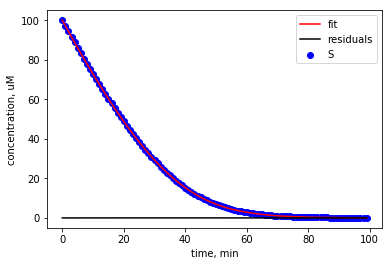

In [29]:
args=tuple(C)
t=data['time']
try:
    z = odeint(modelMM,conc,t,args)
except:
    print("""Couldn't converge or division  
    Check that guesses for KM,Vmax,So,Eo,and data are provided. 
    If the data are pasted from Excel check the end of the table for gibberish text and delete it. 
    Check that the time values in all columns are not duplicated.""")    

data['fit']=z
data['residuals']=(data['S']-data['fit'])

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(data.time, data.S, c='blue')
plt.plot(data.time, data.fit, c='red')
plt.plot(data.time, data.residuals, c='black')

plt.legend()
ax.set_xlabel('time, min')
ax.set_ylabel('concentration, uM')
plt.show()

# Fit to Total Quasi Steady-State Approximation
$$-\frac{\mathrm{d} [S]}{\mathrm{d} t}=k_{cat}\frac{[E]_{o}+K_{M}+[S]-\sqrt{([E]_{o}+K_{M}+[S])^{2}-4E_{o}[S]}}{2
}$$

KM = 39.069624726818745
kcat = 3.973649312952255
E = 1.0005973895117521
RMSE = 0.007337927306658739


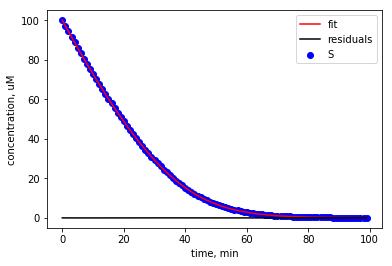

In [30]:
def modelTMM(S,t,*args): #Total Quasi Steady-State Approximation
    KM,kcat,E=args #These are parameters that have to be optimized
    dSdt=-kcat*(E+KM+S-np.sqrt((E+KM+S)**2-4*E*S))/2 # differential equation
    return (dSdt)# returns rates of concentration change

def costTMM(consts,*ARGS):  #consts are the current parameters (rate constants)
    data=ARGS[0]  # the DataFrame with experimental data points
    t=data['time'].values
    So=ARGS[1] # initial concentrations are listed in this variable
    logbounds=ARGS[2]
    if logbounds==True: # if the parameters must be varied over several orders of magnitude 
        args=tuple(np.exp(consts))
    else:
        args=tuple(consts)
    z = odeint(modelTMM,So,t,args) # this is the solution for modelMM: integration of the system of differential equations
    data['fit']=z
    data['residuals']=(data['S']-data['fit'])
    cost=np.sqrt((data['residuals']**2).mean(axis=0))
    return cost

data=pandas.read_csv('../data/simulatedMM.csv')  # Input experimental data
data.dropna(inplace=True)  # clean in case it contains missing data
data=data.loc[:,['time','S']] # read about slicing rules in pandas 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
data.columns=['time','S']  # rename columns for easy referring to each time series
So=  100 # initial substrate  concentration (float)
KM= 200   #initial guess
kcat= 10   #initial guess
E= 0.1   #initial guess
KM_max= 10000   
kcat_max= 10000  
E_max= 10000  
data.head()
logbounds=True # if the parameters must be varied over several orders of magnitude
conc=So
initial_consts=[KM,kcat,E] #initial guess
bnds=[(0,KM_max),(0,kcat_max),(0,E_max)]
if logbounds:
    initial_consts=np.log([KM,kcat,E]) #initial guess
    bnds=[(0,np.log(KM_max)),(0,np.log(kcat_max)),(0,np.log(E_max))]

ARGS=(data,conc,logbounds)
method='L-BFGS-B'
maxiter=50
minimizer_kwargs = {"method":method, "args" :ARGS, "bounds":bnds}
temperature=20 #parameter used in basinhopping
stepsize=10 #parameter used in basinhopping

#constants=minimize(costTMM,initial_consts,args=ARGS,method =method, options={'maxiter': maxiter, 'disp': True})
#constants=basinhopping(cost,initial_consts,minimizer_kwargs=minimizer_kwargs,niter=maxiter,disp=True,T=temperature,stepsize=stepsize)
constants=differential_evolution(costTMM, bnds, args=ARGS, strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=False, polish=True, init='latinhypercube', atol=0)
C=constants.x
if logbounds:
    C=np.exp(constants.x)
#constants
print('KM = {}\nkcat = {}\nE = {}\nRMSE = {}'.format(float(C[0]),float(C[1]),float(C[2]),float(constants.fun)))
data.to_csv('../data/fitted_MM.csv') # save results
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(data.time, data.S, c='blue')
plt.plot(data.time, data.fit, c='red')
plt.plot(data.time, data.residuals, c='black')

plt.legend()
ax.set_xlabel('time, min')
ax.set_ylabel('concentration, uM')
plt.show()
#data.head()


# Fit to Analytical Model
$$[S]=K_{M}LambertW\left \{ {\frac{[S]_{o}}{K_{M}}exp\left ( {\frac{[S]_{o}-V_{max}t}{K_{M}}} \right )} \right \}$$
An advantage of analytical form of function is that we can apply scipy.curve_fit method, which calculates not only fitted parameters but also covariance matrix so we can obtain parameters with errors.

KM=40.12022+/-0.002255
Vm=4.00104+/-9.7e-05
RMSE =  0.00114


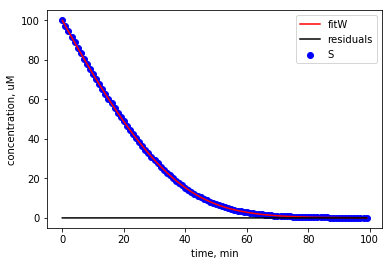

In [31]:
def modelW(t,KM,Vm):
    S=KM*lambertw(So*np.exp((So-Vm*t)/KM)/KM)
    return np.real(S.values)
data=pandas.read_csv('../data/simulatedMM.csv')  # Input simulated data

data.dropna(inplace=True)            # clean in case of missing data
data=data.loc[:,['time','S']] # read about slicing rules in pandas 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
data.columns=['time','S']  # rename columns for easy referring to each time series
#print(data)

So=100
param, param_cov = curve_fit(modelW,data.time,data.S) # run fitting using least square method
KM,Vm=param # open tuple of values
data['fitW']=modelW(data.time,KM,Vm) # add a column with fitted values to our DataFrame 
data['residuals']=data.S-data.fitW
RMSE=np.sqrt(((data.residuals)**2).mean()) 
print('KM={}+/-{}'.format(round(KM,5),round(np.sqrt(param_cov[0][0]),6) ))
print('Vm={}+/-{}'.format(round(Vm,5),round(np.sqrt(param_cov[1][1]),6) ))
print('RMSE = ',round(RMSE,5))
data.to_csv('../data/fitted_W.csv',index=False) #save the table in a file
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(data.time, data.S, c='blue')
plt.plot(data.time, data.fitW, c='red')
plt.plot(data.time, data.residuals, c='black')
plt.legend()
ax.set_xlabel('time, min')
ax.set_ylabel('concentration, uM')
plt.show()

# Fit to first order kinetics (exponential decay) 
$$velocity=-\frac{\mathrm{d} [S]}{\mathrm{d} t}=\frac{V_{max}[S]}{K_{M}}$$


k=0.09975+/-0.0
RMSE =  0.0


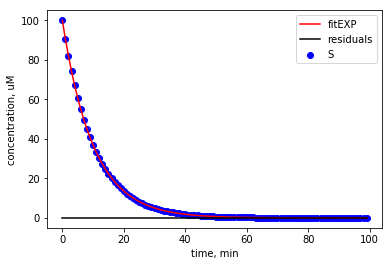

In [32]:
def modelEXP(t,k): #t is independent variable; A,B,C,k1,k2-parameters to be optimized 
    return So*np.exp(-k*t) # returns current substrate concentration
data=pandas.read_csv('../data/simulatedMM.csv')  # Input experimental data
data.dropna(inplace=True)            # clean in case of missing data
data=data.loc[:,['time','EXP']] # read about slicing rules in pandas 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
data.columns=['time','S']  # rename columns for easy referring to each time series
#print(data)
So=100
param, param_cov = curve_fit(modelEXP,data.time,data.S) # run fitting using least square method
k=param[0] # open tuple of values
data['fitEXP']=modelEXP(data.time,k) # add a column with fitted values to our DataFrame 
data['residuals']=data.S-data.fitEXP
RMSE=np.sqrt(((data.residuals)**2).mean()) 
print('k={}+/-{}'.format(round(k,5),round(np.sqrt(param_cov[0][0]),6) ))
print('RMSE = ',round(RMSE,5))
data.to_csv('../data/fitted_W.csv',index=False) #save the table in a file
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(data.time, data.S, c='blue')
plt.plot(data.time, data.fitEXP, c='red')
plt.plot(data.time, data.residuals, c='black')
plt.legend()
ax.set_xlabel('time, min')
ax.set_ylabel('concentration, uM')
plt.show()